In [1]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, ConcatDataset, DataLoader
from PIL import Image

In [2]:
class MNIST(Dataset):
    def __init__(self, dir: str, label: str):
        self.dir = os.path.join(dir, label)
        self.images = os.listdir(self.dir)
        self.label = label

    def __getitem__(self, index: int):
        image_filename = self.images[index]
        image_path = os.path.join(self.dir, image_filename)

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = torch.tensor(image, dtype=torch.float32) / 255

        return image, self.label
    
    def __len__(self):
        return len(self.images)

In [3]:
train_dir = "./MNIST/train/"
test_dir = "./MNIST/test/"

# train_data = MNIST(train_dir, "0")
# test_data = MNIST(test_dir, "0")

labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

train_data = [MNIST(train_dir, label) for label in labels]
train_data = ConcatDataset(train_data)

test_data = [MNIST(test_dir, label) for label in labels]
test_data = ConcatDataset(test_data)

print(f"Number of train images: {len(train_data)}")
print(f"Number of test images: {len(test_data)}")

Number of train images: 60000
Number of test images: 10000


In [4]:
train_data[0]

(tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0392, 0.0039, 0.0000, 0.0157, 0.0000, 0.0000, 0.0314, 0.0000, 0.0157,
          0.0314, 0.0039, 0.0000, 0.0431, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0471,
          0.0000, 0.0000, 0.0706, 0.0000, 0.0000, 0.0784, 0.0000, 0.0431, 0.0000,
          0.0000, 0.0078, 0.0353, 0.0000, 0.0000, 0.0353, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0196, 0.0000, 0.0000, 0.0157, 0.0000, 0.0000, 0.0235, 0.0000, 0.0471,
          0.0196, 0.0000, 0.0275, 0.0157, 0.0039, 0.0118, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039,
          0.0000, 0.0235, 0.0235, 0.0000, 0.0000, 0.0000, 0.0000, 0.0196, 0.0000,
          0.0000, 0.0510, 0.0000, 0.0000,

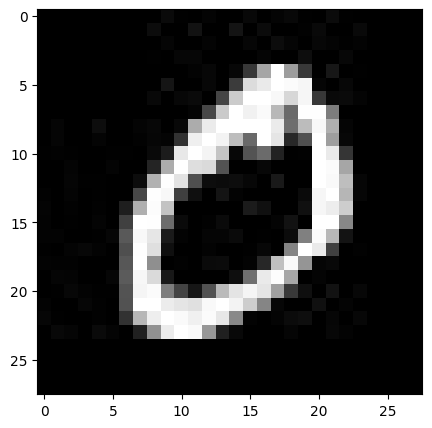

In [5]:
image = Image.fromarray(train_data[0][0].numpy() * 255)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.imshow(image)

In [6]:
class Autoencoder(torch.nn.Module):
    def __init__(self, input_dimension, code_dimension):
        super().__init__()
        self.encoder = torch.nn.Linear(input_dimension, code_dimension)
        self.decoder = torch.nn.Linear(code_dimension, input_dimension)

    def forward(self, x):
        out = self.encoder(x)
        out = torch.nn.functional.relu(out)
        out = self.decoder(out)
        out = torch.nn.functional.sigmoid(out)
        
        return out

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

input_dimension = 28 * 28
code_dimension = 8 * 8
model = Autoencoder(input_dimension, code_dimension).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10

for epoch in range(n_epochs):
    model.train()

    train_loss = 0.0

    for data in train_loader:
        images, labels = data
        images = images.view(images.size(0), -1).to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, images)
        loss.backward()

        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss = train_loss / len(train_loader)
    
    print(f"Epoch: {epoch + 1}, Loss: {train_loss:.4f}")


Epoch: 1, Loss: 0.8073
Epoch: 2, Loss: 0.2536
Epoch: 3, Loss: 0.1938
Epoch: 4, Loss: 0.1778
Epoch: 5, Loss: 0.1705
Epoch: 6, Loss: 0.1663
Epoch: 7, Loss: 0.1635
Epoch: 8, Loss: 0.1613
Epoch: 9, Loss: 0.1596
Epoch: 10, Loss: 0.1584


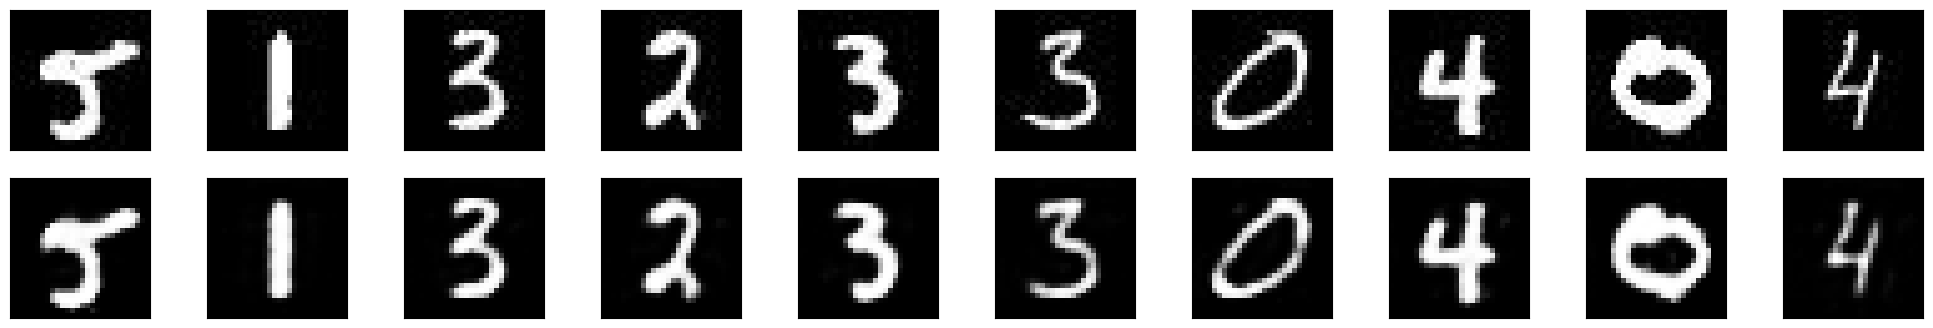

In [8]:
images, labels = next(iter(test_loader))

images_flatten = images.view(images.size(0), -1)

output = model(images_flatten.to(device))

images = images.numpy()

output = output.view(images.shape[0], 1, 28, 28)
output = output.detach().cpu().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25, 4))

for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)